In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Start a session with the API.
qctrl = Qctrl()

Q-CTRL package upgrade available. Your version is 9.4.0. New Version is 9.5.0.


In [2]:
segment_count = 20
duration = 20.
shot_count = 16

In [3]:
# try sending a zero pulse to get the measurements
meas_count = 8192

zero_control = [{"duration": duration, "values":np.zeros(segment_count)}]
experiment_results = qctrl.functions.calculate_qchack_measurements(
controls = zero_control,
shot_count = meas_count,
) 

Your task calculate_qchack_measurements has completed in 3s.


In [4]:
measurements = experiment_results.measurements

In [5]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / meas_count
    p1 = measurement_counts.count(1) / meas_count
    p2 = measurement_counts.count(2) / meas_count
    print(f"control #{k}: P(|0>) = {p0:.3f}, P(|1>) = {p1:.3f}, P(|2>) = {p2:.3f}")


control #0: P(|0>) = 0.991, P(|1>) = 0.009, P(|2>) = 0.000


In [22]:
def run_experiments(omegas, exp_0, exp_1, exp_2):
    """
    Simulates a series of experiments where controls `omegas` attempt to apply
    an X gate to a system. The result of each experiment is the infidelity.

    In your actual implementation, this function would run the experiment with
    the parameters passed. Note that the simulation handles multiple test points,
    while your experimental implementation might need to queue the test point
    requests to obtain one at a time from the apparatus.
    """
    controls1 = []
    controls2 = []
    control_count = np.shape(omegas)[0]
    
    for k in range(control_count):
        controls1.append({"duration": duration, "values": omegas[k], "repetition_count": 63})
        controls2.append({"duration": duration, "values": omegas[k], "repetition_count": 64})
        
    experiment_results1 = qctrl.functions.calculate_qchack_measurements(
controls = controls1,
shot_count = shot_count,
) 
    experiment_results2 = qctrl.functions.calculate_qchack_measurements(
controls = controls2,
shot_count = shot_count,
) 
    
    measurements1 = experiment_results1.measurements
    measurements2 = experiment_results2.measurements
    
    infidelities = []
    for k in range(len(measurements1)):
        p0 = measurements1[k].count(0) / shot_count
        p1 = measurements1[k].count(1) / shot_count
        p2 = measurements1[k].count(2) / shot_count
        
        p01 = measurements2[k].count(0) / shot_count
        p11 = measurements2[k].count(1) / shot_count
        p21 = measurements2[k].count(2) / shot_count
        # Add error to the measurement.
        infidelities.append(abs(p0 - exp_1/2.) + abs(p1 - exp_1/2.) + abs(p01 - exp_1)) 

    return np.array(infidelities)

In [23]:
# Define the number of test points obtained per run.
test_point_count = 20

# Define parameters as a set of controls with piecewise constant segments.
parameter_set = (
    np.pi
    / duration
    * (np.linspace(-1, 1, test_point_count)[:, None])
    * np.ones((test_point_count, segment_count))
)

# Obtain a set of initial experimental results.
experiment_results = run_experiments(parameter_set, 0. ,1., 0.)

Your task calculate_qchack_measurements has completed in 3s.


Your task calculate_qchack_measurements has completed in 3s.


In [24]:
print(experiment_results)

[0.4375 1.0625 0.8125 0.75   1.125  0.875  0.875  1.     1.     1.
 1.     1.     1.     0.875  0.75   0.6875 1.     0.8125 1.     0.5625]


In [25]:
# Define initialization object for the automated closed-loop optimization.
bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=-5 * np.pi / duration,
    upper_bound=5 * np.pi / duration,
)
initializer = qctrl.types.closed_loop_optimization_step.NeuralNetworkInitializer(
    bounds=[bound] * segment_count,
    rng_seed=0,
)

# Define state object for the closed-loop optimization.
optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
    neural_network_initializer=initializer,
)


In [26]:
best_cost, best_controls = min(
    zip(experiment_results, parameter_set), key=lambda params: params[0]
)
optimization_count = 0

sigma = 0.01

# Run the optimization loop until the cost (infidelity) is sufficiently small.
while best_cost > 3 * sigma:
    # Print the current best cost.
    optimization_steps = (
        "optimization step" if optimization_count == 1 else "optimization steps"
    )
    print(
        f"Best infidelity after {optimization_count} BOULDER OPAL {optimization_steps}: {best_cost}"
    )

    # Organize the experiment results into the proper input format.
    results = [
        qctrl.types.closed_loop_optimization_step.CostFunctionResult(
            parameters=list(parameters),
            cost=cost,
            cost_uncertainty=sigma,
        )
        for parameters, cost in zip(parameter_set, experiment_results)
    ]

    # Call the automated closed-loop optimizer and obtain the next set of test points.
    optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
        optimizer=optimizer,
        results=results,
        test_point_count=test_point_count,
    )
    optimization_count += 1

    # Organize the data returned by the automated closed-loop optimizer.
    parameter_set = np.array(
        [test_point.parameters for test_point in optimization_result.test_points]
    )
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        state=optimization_result.state
    )

    # Obtain experiment results that the automated closed-loop optimizer requested.
    experiment_results = run_experiments(parameter_set, 0., 1., 0.)

    # Record the best results after this round of experiments.
    cost, controls = min(
        zip(experiment_results, parameter_set), key=lambda params: params[0]
    )
    if cost < best_cost:
        best_cost = cost
        best_controls = controls

# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)


Best infidelity after 0 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 61s.


Your task calculate_qchack_measurements has completed in 3s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 5s.
Best infidelity after 1 BOULDER OPAL optimization step: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 176s.


Your task calculate_qchack_measurements has completed in 3s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 2 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 117s.


Your task calculate_qchack_measurements has completed in 3s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 3 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 151s.


Your task calculate_qchack_measurements has completed in 3s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 5s.
Best infidelity after 4 BOULDER OPAL optimization steps: 0.1875


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 151s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 11s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 5 BOULDER OPAL optimization steps: 0.0625


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 140s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 5s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 17s.
Best infidelity after 6 BOULDER OPAL optimization steps: 0.0625


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 202s.


Your task calculate_qchack_measurements has completed in 3s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 9s.
Best infidelity after 7 BOULDER OPAL optimization steps: 0.0625


Your task calculate_closed_loop_optimization_step has started.


KeyboardInterrupt: 

Infidelity: 0.0625


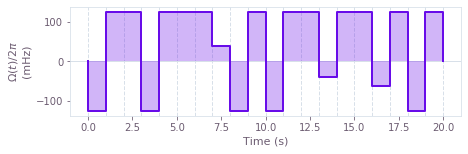

In [27]:
# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)

In [12]:
import jsonpickle

In [28]:
with open("qchack7.json", 'w') as f:
    f.write(jsonpickle.encode({"duration": duration, "values": best_controls}))

In [30]:
with open("qchack7.json", 'r') as f:
    test_dictionary = jsonpickle.decode(f.read())

In [31]:
test_dictionary['values']

array([-0.78539816,  0.78539816,  0.78539816, -0.78539816,  0.78539816,
        0.78539816,  0.78539816,  0.24393992, -0.78539816,  0.78539816,
       -0.78539816,  0.78539816,  0.78539816, -0.24509281,  0.78539816,
        0.78539816, -0.39682108,  0.78539816, -0.78539816,  0.78539816])

In [56]:
# try sending a zero pulse to get the measurements
meas_count = 200

zero_control = [{"duration": test_dictionary['duration'], "values":test_dictionary['values'], "repetition_count":63}]
experiment_results = qctrl.functions.calculate_qchack_measurements(
controls = zero_control,
shot_count = meas_count,
) 

Your task calculate_qchack_measurements has completed in 3s.


In [57]:
measurements = experiment_results.measurements

In [58]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / meas_count
    p1 = measurement_counts.count(1) / meas_count
    p2 = measurement_counts.count(2) / meas_count
    print(f"control #{k}: P(|0>) = {p0:.3f}, P(|1>) = {p1:.3f}, P(|2>) = {p2:.3f}")

control #0: P(|0>) = 0.550, P(|1>) = 0.345, P(|2>) = 0.105
